In [1]:
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
import re
import numpy as np
from matplotlib import gridspec
import matplotlib

# Helper functions

These are borrowed from the `Convert.ipynb` file.

In [2]:
headings = ['Country',
             'City',
             'Quality / Stage of Data',
             'Construction Date',
             'Building Type',
             'Gross Floor Area']

In [3]:
df = pd.read_excel('../Dataset/dataset.xlsx',header=3,index_col=1)
df = df.drop('Unnamed: 0',axis=1).T#.reset_index().rename({'Building Identifier':'index','index':'Building Identifier'},axis=1)
df = df[df.index.str.contains('0')]

In [4]:
df[[c for c in df.columns if 'kg' in c]] = df[[c for c in df.columns if 'kg' in c]].astype('float')

In [5]:
df = pd.concat([df[headings].groupby(lambda x: x.split('.')[0],axis=0).max(),df[[c for c in df.columns if 'kg' in c]].groupby(lambda x: x.split('.')[0],axis=0).mean(numeric_only=True)],axis=1)

In [6]:
name_conversion = pd.read_csv('name_conversion.csv')
building_name_conversion = pd.read_csv('building_type_name_conversion.csv')

In [7]:
building_name_map = {k['Building Code']:k['Building Type'] for _,k in building_name_conversion.iterrows()}

In [8]:
name_map = {k.Code:k.Category for _,k in name_conversion.iterrows()}

In [9]:
additional_categories_map = {v:k for k,v in {
    'Continuous Footings':'0CF',
    'Foundation Walls':'0FW',
    'Spread Footings':'0SF',
    'Column Piers':'0CP',
    'Columns Supporting Floors':'CSF',
    'Floor Girders and Beams':'FGB',
    'Floor Trusses':'0FT',
    'Floor Joists':'0FJ',
    'Columns Supporting Roofs':'CSR',
    'Roof Girders and Beams':'RGB',
    'Roof Trusses':'0RT',
    'Roof Joists':'0RJ',
    'Parking Bumpers':'0PB',
    'Precast Concrete Stair Treads':'PCS',
    'Roof Curbs':'0RC',
    'Exterior Wall Construction':'EWC',
    'Composite Decking':'CPD',
    'Cast-in-Place concrete':'CIC',
    'Floor Structural Frame':'FSF',
    'Associated Metal Fabrications':'AMF',
    'Floor Construction Supplementary Components':'FCS',
    'Roof Construction Supplementary Components':'RCS',
    'Residential Elevators':'0RE',
    'Vegetated Low-Slope Roofing':'VLR',
    'Swimming Pools':'SWP',
    'Excavation Soil Anchors':'ESA',
    'Floor Trusses':'FTS',
    'Roof Window and Skylight Performance':'RWS',
    'Rainwater Storage Tanks':'RST',
    'Gray Water Tanks':'GWT'}.items()
}

additional_categories_map['0FT'] = 'Floor Trusses'

# 1. Plot sample figures

Here we plot building material mass.

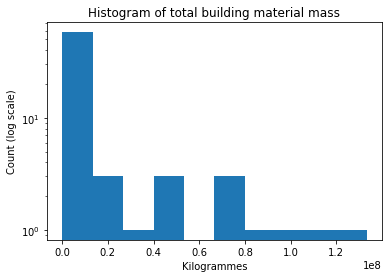

In [10]:
plt.hist(df[[c for c in df.columns if 'kg' in c]].sum(axis=1));
plt.title('Histogram of total building material mass')
plt.yscale('log')
plt.xlabel('Kilogrammes')
plt.ylabel('Count (log scale)');

# 2. Investigate a specific material

In this example, we select only columns that match the MasterFormat code for Concrete. Then, we aggregate based on Level 2 UniFormat code.

In [11]:
cols = [d for d in df.columns if ('_03' in d or '_04 22' in d) and not '_03 20' in d]

In [12]:
f = lambda x: re.split('[_\.\ ]',x)[1][0:3]
concrete_df = pd.concat([df[headings],df[cols].groupby(f,axis=1).sum()],axis=1).rename(columns=name_map)

In [13]:
concrete_df

Building Identifier,Country,City,Quality / Stage of Data,Construction Date,Building Type,Gross Floor Area,Foundations,Subgrade Enclosures,Slabs-On-Grade,Substructure Interior,Water And Gas Mitigation,Substructure Related Activities,Superstructure,Exterior Vertical Enclosures,Exterior Horizontal Enclosures,Interior Construction,Conveying,Plumbing,Special Construction,Site Improvements
001,CA,TOR,00IFC,2021,SND,521.18,1.710150e+05,0.000,6.751475e+04,0.000000e+00,0.0,0.0,1.949675e+03,0.00,0.0,0.000000e+00,0.000,0.0,0.000,0.0000
002,CA,TOR,00IFC,2021,SND,389.24,1.082862e+05,0.000,3.578757e+04,0.000000e+00,0.0,0.0,1.409585e+03,0.00,0.0,0.000000e+00,0.000,0.0,0.000,0.0000
003,CA,TOR,00IFC,2021,SND,411.64,1.911912e+05,0.000,3.254672e+04,0.000000e+00,0.0,0.0,1.562240e+02,0.00,0.0,0.000000e+00,0.000,0.0,0.000,0.0000
004,CA,TOR,00IFC,2021,SND,269.56,6.739916e+04,0.000,1.618022e+04,0.000000e+00,0.0,0.0,2.269760e+01,0.00,0.0,0.000000e+00,0.000,0.0,0.000,0.0000
005,CA,TOR,00IFC,2011,OFF,11248.00,1.278753e+06,1027239.110,6.846302e+05,7.359709e+05,0.0,0.0,7.126901e+06,311760.72,552.0,1.175564e+06,0.000,0.0,0.000,169830.9495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
068,CA,TOR,00IFT,2020,MIX,95769.00,1.566786e+07,3484448.795,1.395514e+06,1.368861e+07,0.0,0.0,5.737703e+07,71331.23,0.0,1.463901e+07,8273703.915,0.0,711760.625,0.0000
069,CA,TOR,00IFC,2019,LNW,131.00,2.657254e+04,0.000,2.924485e+04,0.000000e+00,0.0,0.0,0.000000e+00,0.00,0.0,0.000000e+00,0.000,0.0,0.000,0.0000
070,CA,TOR,0IFBP,2021,LNW,71.00,2.721844e+04,0.000,2.206696e+04,0.000000e+00,0.0,0.0,0.000000e+00,0.00,0.0,0.000000e+00,0.000,0.0,0.000,0.0000
071,CA,TOR,00IFC,2020,LNW,98.00,2.846246e+04,0.000,1.264324e+04,0.000000e+00,0.0,0.0,0.000000e+00,0.00,0.0,0.000000e+00,0.000,0.0,0.000,0.0000


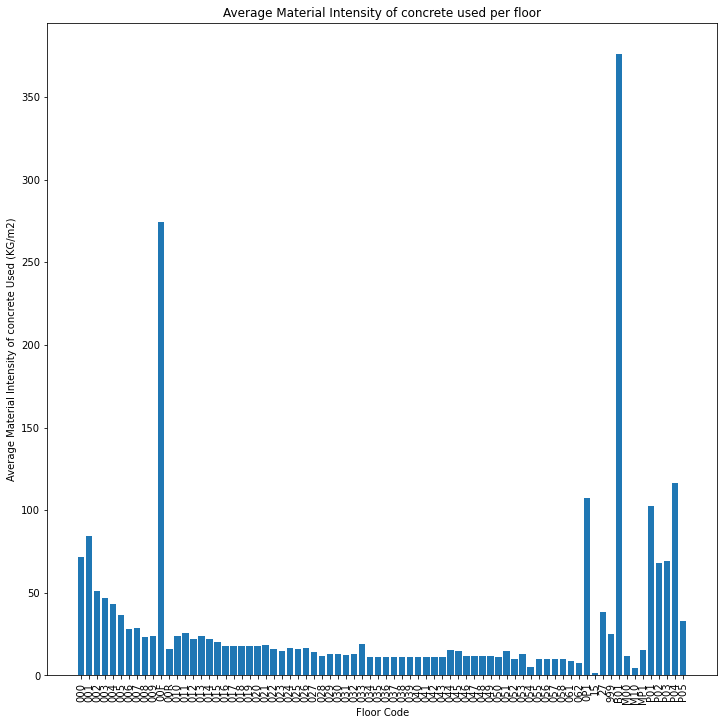

In [14]:
grouping_function = lambda x: x.split('_')[0] #This function takes in a full column name, like "000_G2010.20.000_03 00 00.00_m3_1", and returns only the floor.
to_draw = df[cols].groupby(grouping_function,axis=1).sum().replace(0,np.NaN).div(df['Gross Floor Area'],axis='rows').mean()
plt.figure(figsize=(12,12))
plt.bar(to_draw.keys(), to_draw.values)
plt.xticks(rotation=90)
plt.title('Average Material Intensity of concrete used per floor')
plt.ylabel('Average Material Intensity of concrete Used (KG/m2)')
plt.xlabel('Floor Code');

Now, we will aggregate to Level 3 MasterFormat codes, and display these values for the first three entries.

In [15]:
f = lambda x: name_map[re.split('[_\.\ ]',x)[1][0:3]] #This function takes in a full column name and returns only the Level 3 MasterFormat code.
concrete_df = df[cols].groupby(f,axis=1).sum()

In [16]:
concrete_df.mean().sort_values(ascending=False)

Building Identifier
Superstructure                     6.654056e+06
Substructure Interior              1.694672e+06
Interior Construction              1.646459e+06
Foundations                        1.243325e+06
Subgrade Enclosures                4.858838e+05
Conveying                          4.832128e+05
Slabs-On-Grade                     1.938807e+05
Exterior Vertical Enclosures       1.270600e+05
Exterior Horizontal Enclosures     4.890347e+04
Special Construction               1.500812e+04
Substructure Related Activities    1.174729e+04
Site Improvements                  5.509040e+03
Plumbing                           5.042747e+03
Water And Gas Mitigation           1.185942e+03
dtype: float64

## Pie chart version A: on-pie chart labels for all > 1%

In [ ]:
def my_autopct(pct):
    return ('%.2f' % pct) if pct > 1 else ''
to_plot = concrete_df.mean().sort_values(ascending=False)
to_plot.plot.pie(figsize=(12,12),colormap='tab20',autopct=my_autopct,labels=[k if v > 35000 else '' for k,v in to_plot.items()])
plt.ylabel('')
plt.title('Percentage of total concrete used in each building element category');
# plt.legend(loc='center left',bbox_to_anchor=(-0.20, 0.75));
plt.tight_layout();

## Pie version B: external legend with slice labels

In [ ]:
fig = plt.figure(figsize=(16,12)) 
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1])
ax0 = plt.subplot(gs[:,0])

def my_autopct(pct):
    return ('%.2f' % pct) if pct > 1 else ''
to_plot = concrete_df.mean().sort_values(ascending=False)
to_plot.plot.pie(ax=ax0,colormap='tab20',autopct=my_autopct,labeldistance=None)
plt.ylabel('')
plt.legend(loc='center left',bbox_to_anchor=(-0.20, 0.75));
plt.tight_layout();

ax1 = plt.subplot(gs[0,1])
f = lambda x: \
    additional_categories_map[re.split('[_\.\ ]',x)[3]] \
    if \
    re.split('[_\.\ ]',x)[3] != '000' \
    else \
    name_map['.'.join(re.split('[_\.\ ]',x)[1:3])]

superstructure_df = df[[c for c in cols if 'B10' in c]].groupby(f,axis=1).sum()
to_plot = superstructure_df.mean().sort_values(ascending=False)
def my_autopct(pct):
    return ('%.2f' % ((pct * 0.4335))) if pct > 1 else ''
to_plot.plot.pie(ax=ax1,colormap='tab20b',autopct=my_autopct,labeldistance=None)
plt.ylabel('')
plt.legend(loc='center right',bbox_to_anchor=(1, -0.65));
plt.tight_layout();

transFigure = fig.transFigure.inverted()

coord1a = transFigure.transform(ax0.transData.transform([1,0]))
coord2a = transFigure.transform(ax1.transData.transform([0,-0.72]))

coord1b = transFigure.transform(ax0.transData.transform([-0.91,0.35]))
coord2b = transFigure.transform(ax1.transData.transform([0,0.72]))

linea = matplotlib.lines.Line2D((coord1a[0],coord2a[0]),(coord1a[1],coord2a[1]),
                               transform=fig.transFigure,c='black',alpha=0.7)
lineb = matplotlib.lines.Line2D((coord1b[0],coord2b[0]),(coord1b[1],coord2b[1]),
                                transform=fig.transFigure,c='black',alpha=0.7)
fig.lines = linea,lineb,

plt.savefig('concrete_breakdown_pie.pdf')

We can produce a pie chart for a single building, also.

In [ ]:
mf_codes = pd.read_csv('mf_name_conversion.csv')

In [ ]:
tofind = [
    'Plain Steel Reinforcement Bars',
    'Reinforcement Bars',
    'Structural Steel Framing',
    'Fabric and Grid Reinforcing',
    'Metal Doors',
    'Metal Roof Panel',
    'Metal Stairs',
    'Metal Railings',
    'Steel Decking',
    'Steel Joist Framing',
    'Steel'
] #List of terms we are looking to identify in column names.

tokeep = [
    c for c in mf_codes.Title.values if any(t in c for t in tofind)
] #For each codes' corresponding in MasterFormat

steel_codes = mf_codes[mf_codes.Title.isin(tokeep)]

In [ ]:
columns_to_keep = []
for column in df.columns:
    if 'kg' in column:
        code = re.split('_',column)[2]
        for k,c in steel_codes.values:
            if c in code:
                columns_to_keep.append(column)

In [ ]:
f = lambda x: mf_codes[mf_codes.Code == str.replace(re.split('_',x)[2],'00','').split('.')[0]].values[0][0]
steel_df = df[columns_to_keep].groupby(f,axis=1).sum()

In [ ]:
(steel_df>0).sum(axis=1).sort_values()

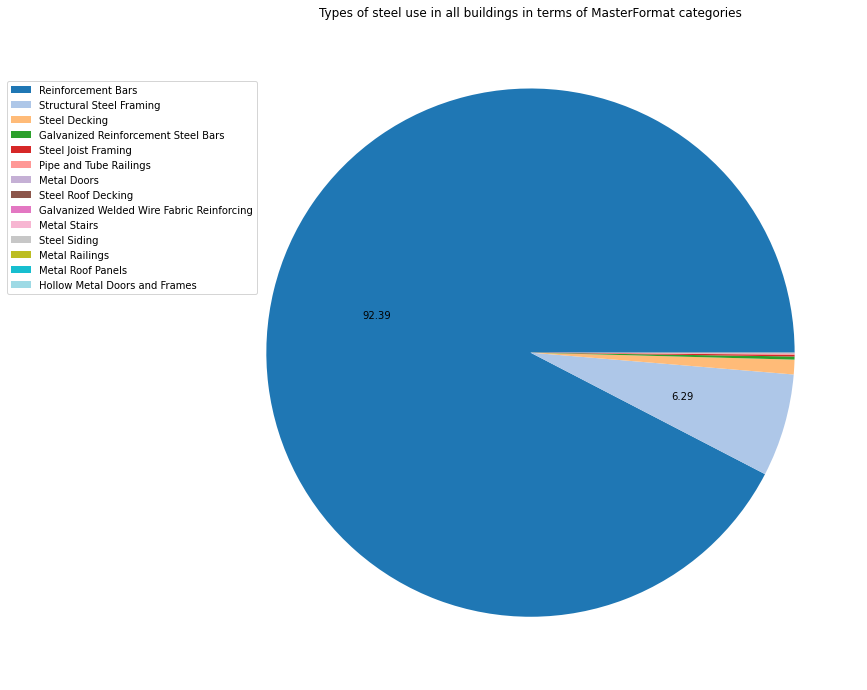

In [24]:
def my_autopct(pct):
    return ('%.2f' % (pct)) if pct > 1 else ''
to_plot = steel_df.sum().sort_values(ascending=False)
to_plot.plot.pie(figsize=(12,12),colormap='tab20',autopct=my_autopct,labeldistance=None)
plt.legend(loc='center left',bbox_to_anchor=(-0.30, 0.75));

plt.ylabel('')
plt.title(f'Types of steel use in all buildings in terms of MasterFormat categories');
plt.tight_layout();

plt.savefig('steel_composition_pie.pdf')

In [25]:
f = lambda x: mf_codes[mf_codes.Code.str.contains(str.replace(re.split('_',x)[2],'00','').split('.')[0].strip())].values[0][0] + '/' + x.split('_')[0]
tdf = df[columns_to_keep].groupby(f,axis=1).sum().iloc[47,:]
tdf = tdf[tdf>0]

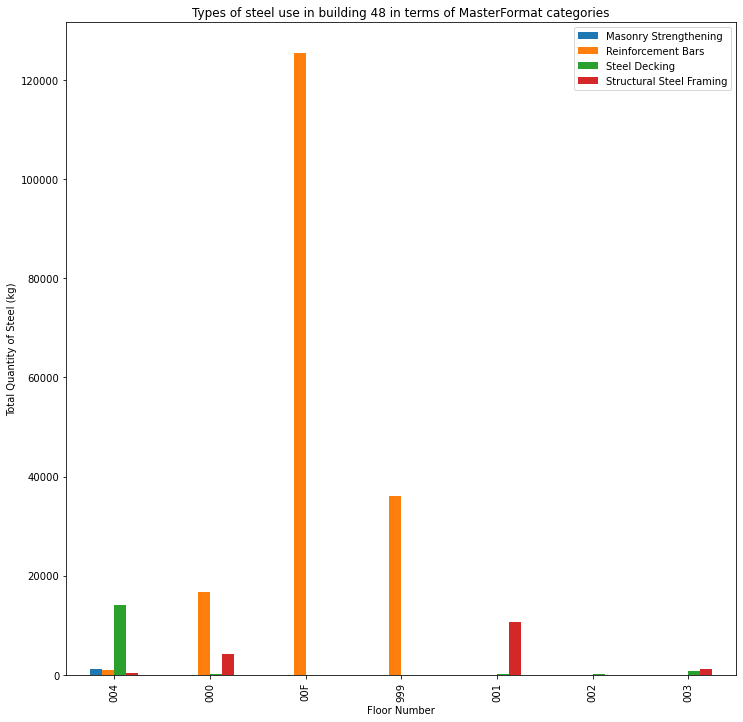

In [26]:
from collections import defaultdict
todf = defaultdict(dict)
for (a,b),c in zip(tdf.keys().str.split('/'),tdf.values):
    todf[a][b] = c
toplot = pd.DataFrame(todf)
toplot.plot.bar(figsize=(12,12));
plt.xlabel('Floor Number')
plt.ylabel('Total Quantity of Steel (kg)')
plt.title('Types of steel use in building 48 in terms of MasterFormat categories')
plt.savefig('bar_steel_onebuildingtype_byfloor.pdf')

We can also calculate the average for each Level 3 MasterFormat code by year of construction:

In [27]:
concrete_df = pd.concat([df[headings[1:]],df[cols].groupby(f,axis=1).sum()],axis=1)
concrete_df.groupby('Construction Date').mean()

Building Identifier,Gross Floor Area,Cast Decks and Underlayment/002,Cast Decks and Underlayment/003,Cast Decks and Underlayment/999,Cast-in-Place Concrete/000,Cast-in-Place Concrete/001,Cast-in-Place Concrete/002,Cast-in-Place Concrete/003,Cast-in-Place Concrete/004,Cast-in-Place Concrete/005,...,Structural Concrete/999,Structural Concrete/B01,Structural Concrete/M00,Structural Concrete/M10,Structural Concrete/MP1,Structural Concrete/P01,Structural Concrete/P02,Structural Concrete/P03,Structural Concrete/P04,Structural Concrete/P05
Construction Date,,,,,,,,,,,,,,,,,,,,,
1913,161.080000,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,64035.190000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1917,199.930000,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,114018.460000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969,373.605000,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,132278.015000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1988,21934.000000,0.0,0.0,0.000000e+00,3.999773e+06,1.435583e+06,1.502795e+06,1.423554e+06,1.318964e+06,788129.689933,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007,73600.000000,0.0,0.0,1.329816e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009,73083.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011,11282.500000,54943.2,65145.6,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016,26841.666667,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,156360.0,0.000000,141136.0,0.0,0.0,1471112.0,1143352.0,1064296.0,6087984.0,0.0
2017,35280.510000,0.0,0.0,2.587372e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,205476.0,0.000000,0.0,0.0,0.0,2764302.0,2067108.0,2037768.0,1602108.0,609738.0


We can get the average amount of steel in KG used per building type:

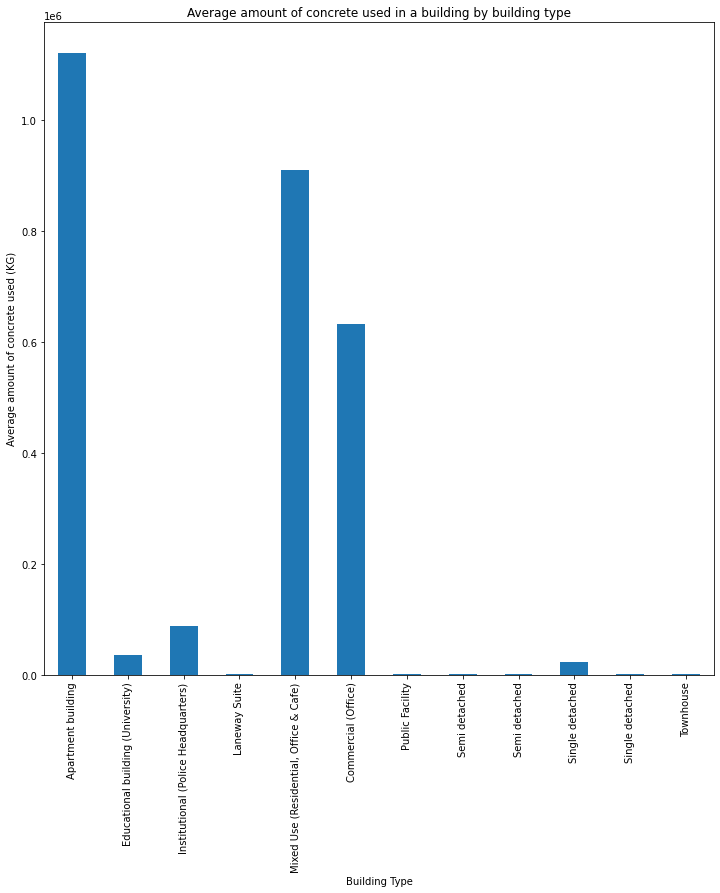

In [28]:
concrete_df.groupby('Building Type').sum().mean(axis=1).rename(index=building_name_map).plot(kind='bar',figsize=(12,12))
plt.ylabel('Average amount of concrete used (KG)')
plt.title('Average amount of concrete used in a building by building type');

# 3. Uncertainty by Building Type

In this section, we look at the uncertainty score associated with each material takeoff. We collect these by building type and then report the number of each value per type of building.

In [29]:
uncertainty_level = {} 
for k,v in df.iterrows():
    #Initialise empty lists for each building type as they occur
    if v['Building Type'] not in uncertainty_level.keys():
        uncertainty_level[v['Building Type']] = []
    #Append the uncertainty value for each column that is non-NaN
    for key in v[~v.isna()].keys()[7:]:
        uncertainty_level[v['Building Type']].append(key.split('_')[-1])

In [30]:
from collections import Counter

In [31]:
for k,v in uncertainty_level.items():
    uncertainty_level[k] = Counter(v) #Construct a Counter object per building type

In [32]:
uncertainty_level

{'SND': Counter({'3': 626, '2': 1582, '5': 284}),
 'OFF': Counter({'2': 491, '4': 307}),
 'APB': Counter({'2': 1844, '3': 1, '4': 1601}),
 'SMR': Counter({'2': 20, '3': 26, '5': 8}),
 'SNR': Counter({'2': 55, '3': 70, '5': 52}),
 'SMD': Counter({'2': 167, '3': 34, '5': 19}),
 'EDU': Counter({'2': 91, '4': 24, '3': 6}),
 'INS': Counter({'4': 77, '2': 89, '3': 1}),
 'MIX': Counter({'2': 1262, '4': 1047}),
 'LNW': Counter({'3': 92, '2': 287, '5': 21}),
 'PUF': Counter({'2': 30, '4': 4}),
 'TWN': Counter({'2': 58, '4': 6})}

Next, we aggregate columns by the purporse of the material and uncertainty combined, and report the average by building type.

In [33]:
f = lambda x: name_map[re.split('[_\.\ ]',x)[1][0]] + '/' + x.split('_')[-1].split('.')[0] #From a full code, return only the use code and uncertainty score.
by_function_df = pd.concat([df[headings[1:]],df[cols].groupby(f,axis=1).sum()],axis=1)

In [34]:
by_function_df.groupby('Building Type').mean().rename(index=building_name_map).drop(['Construction Date'],axis=1).round(2)

Building Identifier,Gross Floor Area,Interiors/2,Interiors/3,Interiors/4,Services/2,Services/4,Shell/2,Shell/3,Shell/4,Shell/5,Sitework/2,Sitework/4,Special Construction And Demolition/2,Special Construction And Demolition/4,Substructure/2,Substructure/3,Substructure/4,Substructure/5
Building Type,,,,,,,,,,,,,,,,,,
Apartment building,39160.26,5624203.35,0.00,171337.00,1529274.0,50074.69,20886862.84,0.00,761128.06,0.00,14493.0,474.04,37698.0,339.88,15661850.24,109212.00,365922.73,0.00
Educational building (University),7901.00,480382.15,3096.66,14080.27,0.0,0.00,1520252.59,834695.64,7713.03,0.00,0.0,0.00,0.0,0.00,2793438.68,0.00,91853.12,0.00
Institutional (Police Headquarters),21934.00,1295281.75,0.00,40860.46,0.0,0.00,17371405.92,0.00,656655.11,0.00,0.0,0.00,0.0,0.00,8890567.75,0.00,239579.15,0.00
Laneway Suite,128.88,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,48858.34,2104.66,0.00,0.65
"Mixed Use (Residential, Office & Cafe)",80760.42,12716484.57,0.00,370412.46,7268736.0,237801.46,51743951.21,0.00,1909970.03,0.00,0.0,0.00,249760.0,9000.47,22801051.57,0.00,645320.97,0.00
Commercial (Office),52643.67,9898215.44,0.00,285637.96,0.0,0.00,43308969.36,0.00,1621345.80,0.00,89288.0,3016.86,0.0,0.00,12411535.27,0.00,354767.84,0.00
Public Facility,62.00,18518.82,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,66060.00,0.00,1990.25,0.00
Semi detached,248.84,0.00,0.00,0.00,0.0,0.00,1866.95,5.41,0.00,0.00,0.0,0.00,0.0,0.00,97751.05,7.78,0.00,6.93
Semi detached,199.93,0.00,0.00,0.00,0.0,0.00,0.00,40.11,0.00,0.00,0.0,0.00,0.0,0.00,110261.75,8921.68,0.00,0.00


Next, we report the total amount of material falling under each uncertainty score by year of construction.

In [35]:
f = lambda x: x.split('_')[-1].split('.')[0] #Select only the uncertainty score.
print('Average amount of material used per building, by year and uncertainty score (%)')
result = pd.concat([df['Construction Date'],df[[c for c in df.columns if 'kg' in c]].groupby(f,axis=1).sum()],axis=1).groupby('Construction Date').mean()
for k,v in result.iterrows():
    result.loc[k,:] = v/v.sum()
display(result.round(2))

Average amount of material used per building, by year and uncertainty score (%)


,2,3,4,5
Construction Date,,,,
1913,0.85,0.08,0.00,0.07
1917,0.75,0.14,0.00,0.11
1969,0.50,0.37,0.00,0.13
1988,0.97,0.00,0.03,0.00
2007,0.97,0.00,0.03,0.00
2009,0.97,0.00,0.03,0.00
2011,0.94,0.03,0.03,0.00
2016,0.96,0.02,0.03,0.00
2017,0.97,0.00,0.03,0.00


# 4. Material Intensity

We can easily calculate material intensity by dividing takeoffs which are measured in kilograms by the `Gross Floor Area`:

In [36]:
kilogram_columns = [d for d in df.columns if 'kg' in d]
df_mi = df[kilogram_columns].div(df['Gross Floor Area'],axis=0)

In [37]:
kilogram_columns = [d for d in df.columns if 'kg' in d]
df_mi = df[kilogram_columns].div(df['Gross Floor Area'],axis=0)
f = lambda x: name_map[re.split('[_\.\ ]',x)[1][0:3]]
pd.concat([df[headings[1:]],df_mi[kilogram_columns].groupby(f,axis=1).sum()],axis=1)[df['Building Type'] == 'SND']

Building Identifier,City,Quality / Stage of Data,Construction Date,Building Type,Gross Floor Area,Conveying,Exterior Horizontal Enclosures,Exterior Vertical Enclosures,Foundations,Interior Construction,Interior Finishes,Plumbing,Site Improvements,Slabs-On-Grade,Special Construction,Subgrade Enclosures,Substructure Interior,Substructure Related Activities,Superstructure,Water And Gas Mitigation
001,TOR,00IFC,2021,SND,521.18,0.0,11.137992,136.939623,335.649367,16.482129,6.202080,0.0,0.0,273.972401,0.0,9.652903,7.521547,0.0,30.228003,0.0
002,TOR,00IFC,2021,SND,389.24,0.0,5.461939,69.018253,281.318698,12.248343,4.491260,0.0,0.0,192.874465,0.0,6.851955,11.871041,0.0,26.271523,0.0
003,TOR,00IFC,2021,SND,411.64,0.0,3.786074,101.450370,464.462195,15.931829,3.030369,0.0,0.0,170.733356,0.0,11.298572,8.277288,0.0,23.756286,0.0
004,TOR,00IFC,2021,SND,269.56,0.0,6.503479,188.215196,255.359136,4.574132,2.920482,0.0,0.0,124.186526,0.0,4.351465,20.070275,0.0,30.396721,0.0
007,TOR,00IFC,2021,SND,445.99,0.0,11.933511,61.325975,295.116668,19.773909,4.539900,0.0,0.0,153.061618,0.0,9.478642,5.575509,0.0,39.906513,0.0
008,TOR,00IFC,2021,SND,438.45,0.0,12.707195,130.552921,269.468463,10.683759,4.767511,0.0,0.0,211.910108,0.0,4.218921,1.817270,0.0,39.907474,0.0
009,TOR,00IFC,2021,SND,714.07,0.0,12.865930,104.310510,276.917123,18.937583,4.898301,0.0,0.0,266.709576,0.0,8.902623,25.192687,0.0,38.291591,0.0
010,TOR,00IFC,2021,SND,343.24,0.0,4.300619,210.632241,283.893850,17.891930,6.753884,0.0,0.0,138.510228,0.0,9.601245,7.744759,0.0,35.370538,0.0
013,TOR,00IFC,2021,SND,226.89,0.0,12.424245,186.668275,261.874926,17.256393,4.154604,0.0,0.0,129.263543,0.0,3.818403,9.532825,0.0,35.355314,0.0
014,TOR,00IFC,2021,SND,611.73,0.0,5.140200,102.332008,343.714248,13.258982,5.577869,0.0,0.0,165.513154,0.0,7.722754,6.168162,0.0,33.388004,0.0


In [38]:
master_format_convert = {v:k for k,v in {
    'Concrete':'03',
    'Masonry':'04',
    'Metals':'05',
    'WoodPlasticsAndComposites':'06',
    'ThermalAndMoistureProtection':'07',
    'Finishes':'09',
    'Openings':'08',
    'Earthwork':'31',
    'ExteriorImprovements':'32'
}.items() }

In [39]:
f = lambda x: master_format_convert[re.split('[_\.\ ]',x)[4]]
toplot = pd.concat([df[headings[1:]],df_mi[kilogram_columns].groupby(f,axis=1).sum()],axis=1).sort_values(['Building Type'])

In [40]:
building_type_map = {
    'APB':'Mid to high-rise buildings',
    'EDU':'Mid to high-rise buildings',
    'INS':'Mid to high-rise buildings',
    'MIX':'Mid to high-rise buildings',
    'OFF':'Mid to high-rise buildings',
    'PUF':'Mid to high-rise buildings',
    'TWN':'Other',
    'SND':'Newly Constructed Single family dwellings',
    'SNR':'Renovated Single family dwellings',
    'SMD':'Newly Constructed Single family dwellings',
    'SMR':'Renovated Single family dwellings',
    'ADU':'Other',
    'SEC':'Other',
    'ROW':'Other',
    'LNW':'Laneway Houses'
}

toplot['Building Type'] = toplot['Building Type'].replace(building_type_map)
toplot = toplot.sort_values('Building Type')

In [41]:
set(df['Building Type'].values)

{'APB',
 'EDU',
 'INS',
 'LNW',
 'MIX',
 'OFF',
 'PUF',
 'SMD',
 'SMR',
 'SND',
 'SNR',
 'TWN'}

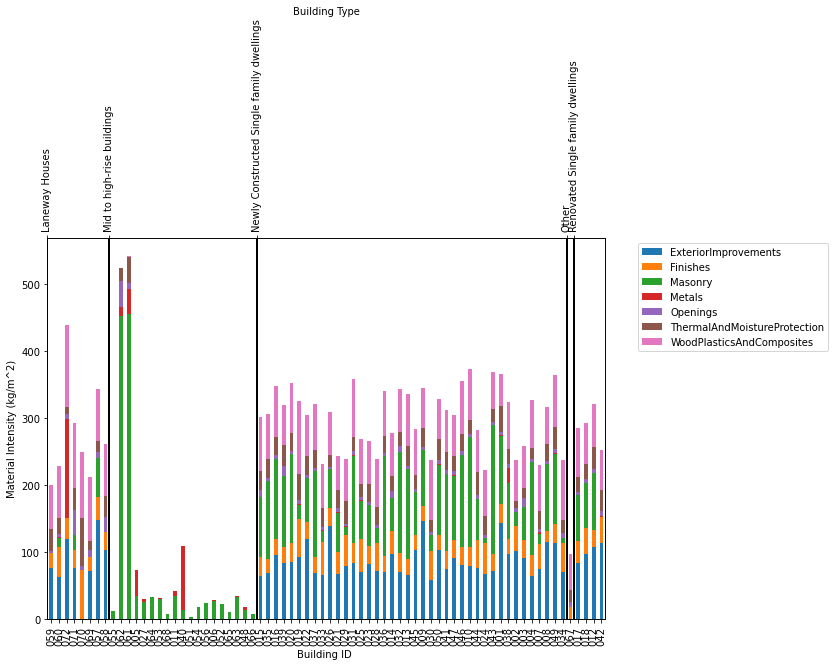

In [42]:
fig, ax = plt.subplots(figsize=(10,7))  

cols = toplot.columns[6:]
margin_bottom = np.zeros(len(toplot))

cmap = plt.get_cmap('tab10')

for num, col in enumerate(cols):
    values = toplot[col].values

    toplot[col].plot.bar(x='Year',y='Value', ax=ax, stacked=True, 
                                    bottom = margin_bottom, color=cmap(num), label=col)
    margin_bottom += values
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Material Intensity (kg/m^2)')
plt.xlabel('Building ID ')
ax2 = ax.twiny()
ax2.set_xlim(0, len(toplot))
ax2.set_xticks([k for k,v in enumerate(toplot['Building Type'].values) if v != toplot['Building Type'].values[k-1] or k==0])
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)
ax2.set_xticklabels([v for k,v in enumerate(toplot['Building Type'].values) if v != toplot['Building Type'].values[k-1] or k==0])
ax2.set_xlabel("Building Type")
plt.grid(color='black',linewidth=2)

plt.show()


In [43]:
toplot['Total MI'] = toplot.iloc[:,6:].sum(axis=1)

In [44]:
print('Mean Material Intensity:')
display(toplot.groupby('Building Type').mean().iloc[:,1:].round(2))
print('Std Dev Material Intensity:')
display(toplot.groupby('Building Type').std().iloc[:,1:].round(2))

Mean Material Intensity:


Building Identifier,Gross Floor Area,Concrete,ExteriorImprovements,Finishes,Masonry,Metals,Openings,ThermalAndMoistureProtection,WoodPlasticsAndComposites,Total MI
Building Type,,,,,,,,,,
Laneway Houses,128.88,412.96,81.80,35.26,11.68,18.65,12.42,28.81,89.25,277.86
Mid to high-rise buildings,39544.96,1121.15,0.00,0.00,65.63,10.77,2.53,3.10,0.03,82.05
Newly Constructed Single family dwellings,461.18,396.71,86.16,31.17,83.77,0.96,5.99,25.63,68.82,302.51
Other,3566.00,153.88,0.00,17.91,0.00,0.00,7.04,17.50,54.38,96.83
Renovated Single family dwellings,277.06,442.97,100.30,33.64,55.31,0.74,5.84,26.98,64.59,287.39


Std Dev Material Intensity:


Building Identifier,Gross Floor Area,Concrete,ExteriorImprovements,Finishes,Masonry,Metals,Openings,ThermalAndMoistureProtection,WoodPlasticsAndComposites,Total MI
Building Type,,,,,,,,,,
Laneway Houses,50.64,150.56,43.53,17.14,20.51,52.54,11.58,19.63,17.69,79.65
Mid to high-rise buildings,33179.20,194.09,0.00,0.00,137.21,23.54,9.04,9.87,0.12,160.80
Newly Constructed Single family dwellings,168.17,82.14,22.30,9.40,49.26,3.35,2.21,6.14,11.58,46.39
Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Renovated Single family dwellings,117.28,120.26,12.94,6.38,37.88,0.86,1.43,5.44,6.55,28.36


In [45]:
df_mi = df[kilogram_columns].div(df['Gross Floor Area'],axis=0)

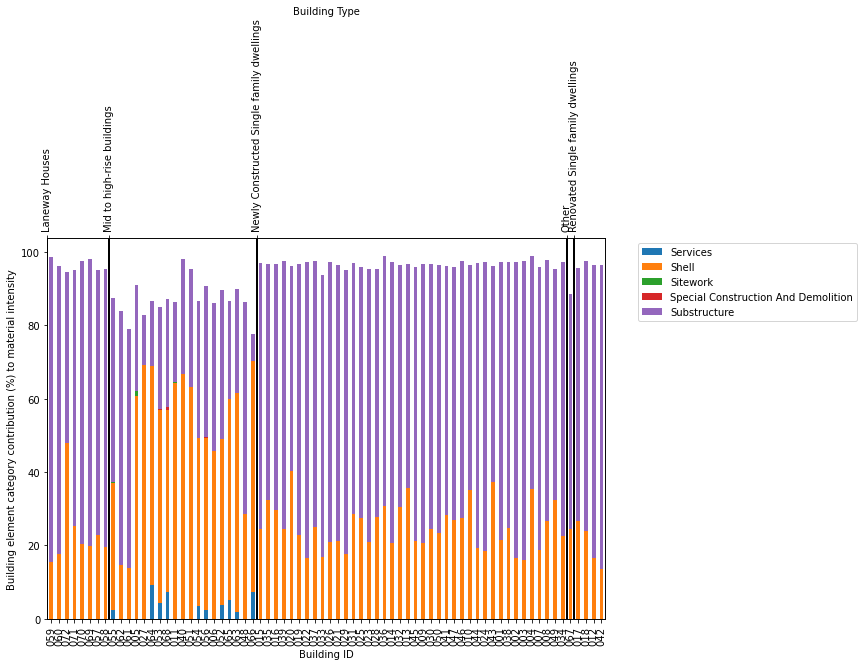

In [46]:
df_mi = df[kilogram_columns].div(df['Gross Floor Area'],axis=0)
df_mi = df_mi.div(df_mi.sum(axis=1),axis=0) * 100
f = lambda x: name_map[re.split('[_\.\ ]',x)[1][0]]
toplot = pd.concat([df[headings[1:]],df_mi[kilogram_columns].groupby(f,axis=1).sum()],axis=1).sort_values('Building Type')
toplot['Building Type'] = toplot['Building Type'].replace(building_type_map)
toplot = toplot.sort_values('Building Type')
fig, ax = plt.subplots(figsize=(10,7))  

cols = toplot.columns[6:]
margin_bottom = np.zeros(len(toplot))

cmap = plt.get_cmap('tab10')

for num, col in enumerate(cols):
    values = toplot[col].values

    toplot[col].plot.bar(x='Year',y='Value', ax=ax, stacked=True, 
                                    bottom = margin_bottom, color=cmap(num), label=col)
    margin_bottom += values
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Building ID')
plt.ylabel('Building element category contribution (%) to material intensity')

ax2 = ax.twiny()
ax2.set_xlim(0, len(toplot))
ax2.set_xticks([k for k,v in enumerate(toplot['Building Type'].values) if v != toplot['Building Type'].values[k-1] or k==0])
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)
ax2.set_xticklabels([v for k,v in enumerate(toplot['Building Type'].values) if v != toplot['Building Type'].values[k-1] or k==0])
ax2.set_xlabel("Building Type")
plt.grid(color='black',linewidth=2)
plt.show()

In [47]:
f = lambda x: name_map[re.split('[_\.\ ]',x)[1][0]] + '/' + re.split('[_\.\ ]',x)[-1]
toplot = df_mi[kilogram_columns].groupby(f,axis=1).sum()

In [48]:
df_mi = df[kilogram_columns].div(df['Gross Floor Area'],axis=0)
df_mi = df_mi.div(df_mi.sum(axis=1),axis=0)
f = lambda x: name_map[re.split('[_\.\ ]',x)[1][0]] + '/' + re.split('[_\.\ ]',x)[-1]
toplot = df_mi[kilogram_columns].groupby(f,axis=1).sum()
for i in range(1,6):
    toplot[f'Total/{i}'] = 0
for k,v in toplot.iteritems():
    toplot[f'Total/{k.split("/")[1]}'] += v
toplot_out = deepcopy(toplot)
for k,v in toplot.iteritems():
    toplot_out[k] = (v/toplot[[c for c in toplot.columns if k.split('/')[0] in c]].sum(axis=1)) * int(k.split('/')[1])
f = lambda x: x.split('/')[0]
toplot_out = pd.concat([df['Building Type'],toplot_out.groupby(f,axis=1).sum()],axis=1).sort_values('Building Type')
toplot_out = toplot_out.reset_index()
toplot_out['index'] = toplot_out['index'].astype('int') + 1
toplot_out['index'] = toplot_out['index'].astype('str')

In [49]:
# toplot_out = toplot_out[toplot_out['Building Type'].isin(types_to_keep)]
toplot_out['Building Type'] = toplot_out['Building Type'].replace(building_type_map)
toplot_out = toplot_out.sort_values('Building Type')

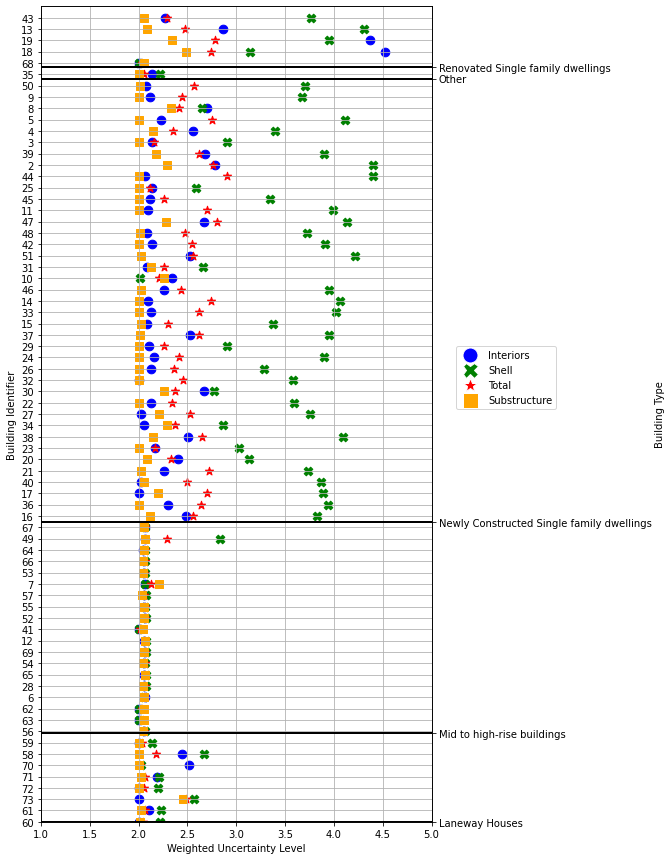

In [50]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(7,15)) 
ax.set_xlim(1,5)
ax.set_ylim(0,len(toplot_out))
# ax.set_yticks(toplot_out['index'])
handles = []
for v,m,c in [('Interiors','o','blue'),('Shell','X','green'),('Total','*','red'),('Substructure','s','orange')]:
    ax.scatter(x=toplot_out[v].values,y=toplot_out['index'].values, marker=m, color=c, s=75)
    handles.append(
        Line2D([0], [0], marker=m, color='w', label=v,
                              markerfacecolor=c, markersize=15)
    )
plt.legend(handles=handles,bbox_to_anchor=(1.05, 0.5), loc='lower left')
plt.ylabel('Building Identifier')
plt.xlabel('Weighted Uncertainty Level')
plt.grid()
ax2 = ax.twinx()
ax2.set_ylim(0, len(toplot_out))
ax2.set_yticks([k-1.5 for k,v in enumerate(toplot_out['Building Type'].values) if v != toplot_out['Building Type'].values[k-1] or k==0])
# for tick in ax2.get_yticklabels():
#     tick.set_rotation(90)
ax2.set_yticklabels([v for k,v in enumerate(toplot_out['Building Type'].values) if v != toplot_out['Building Type'].values[k-1] or k==0])
ax2.set_ylabel("Building Type")


plt.grid(color='black',linewidth=2)

In [51]:
toplot_out

,index,Building Type,Interiors,Services,Shell,Sitework,Special Construction And Demolition,Substructure,Total
18,60,Laneway Houses,2.000000,0.0,2.222478,0.0,0.0,2.009786,2.042591
17,61,Laneway Houses,2.106514,0.0,2.229146,0.0,0.0,2.024653,2.063625
16,73,Laneway Houses,2.000000,0.0,2.571212,0.0,0.0,2.457455,2.487226
11,72,Laneway Houses,2.005075,0.0,2.200763,0.0,0.0,2.000000,2.051110
12,71,Laneway Houses,2.190950,0.0,2.206190,0.0,0.0,2.023037,2.064759
...,...,...,...,...,...,...,...,...,...
71,68,Other,2.000000,0.0,2.000000,0.0,0.0,2.050328,2.032276
68,18,Renovated Single family dwellings,4.523878,0.0,3.139931,0.0,0.0,2.480406,2.744405
69,19,Renovated Single family dwellings,4.371953,0.0,3.946027,0.0,0.0,2.342662,2.777552
30,13,Renovated Single family dwellings,2.868511,0.0,4.306551,0.0,0.0,2.082720,2.475825


# Additional Characteristics

In [52]:
from collections import Counter
import re
import eeweather
BUILDING_ID = '043'
building_data = df.loc[BUILDING_ID]

In [53]:
seen = set()
c = Counter()
for k,v in building_data.items():
    floor = k.split('_')[0]
    if floor in seen or v!=v or 'kg' not in k:
        continue
    seen.add(floor)
for x in seen:
    parts = re.split('([A-Z])',x)
    parts = [p for p in parts if p!='']
    parts = [int(p) if p.isdigit() else p for p in parts]
    if 'B' in parts:
        c.update(['Basement'])
    elif 'R' in parts:
        c.update(['Roof'])
    elif 0 in parts:
        c.update(['Ground'])
    else:
        c.update(['Above Ground'])
print(c)

Counter({'Above Ground': 2, 'Basement': 1, 'Ground': 1, 'Roof': 1})


In [54]:
from geopy.geocoders import Nominatim
locator = Nominatim(user_agent="ConstructionDataset")
name_map = {
    'TOR':'Toronto',
    'WIN':'Winnipeg',
    'NEW':'New York',
    'RIC':'Richmond',
    'MIS':'Mississuaga'
}
location = locator.geocode(f'{name_map[building_data.City]}, {building_data.Country}')

In [55]:
ranked_stations = eeweather.rank_stations(location.latitude,location.longitude)
ranked_stations = ranked_stations[~ranked_stations.iecc_climate_zone.isnull()]
station, warnings = eeweather.select_station(ranked_stations)

In [56]:
station.climate_zones

{'iecc_climate_zone': '5',
 'iecc_moisture_regime': 'A',
 'ba_climate_zone': 'Cold',
 'ca_climate_zone': None}

In [57]:
location

Location(Old Toronto, Toronto, Golden Horseshoe, Ontario, Canada, (43.6534817, -79.3839347, 0.0))